In [63]:
import pandas as pd
import os

# Define column names
columns = ['patient_id', 'filename', 'class', 'data_source']

# Read the files
df_train = pd.read_csv('covidx/train.txt', sep=' ', header=None, names=columns)
df_train['split'] = 'train'

df_val = pd.read_csv('covidx/val.txt', sep=' ', header=None, names=columns)
df_val['split'] = 'val'

df_test = pd.read_csv('covidx/test.txt', sep=' ', header=None, names=columns)
df_test['split'] = 'test'

# Concatenate into a single dataframe
df = pd.concat([df_train, df_val, df_test], ignore_index=True)


# Display the first few rows
df.head()

,patient_id,filename,class,data_source,split
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen,train
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen,train
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen,train
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen,train
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen,train


In [64]:
# Display dataframe info
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 84818 entries, 0 to 84817
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   patient_id   84818 non-null  str  
 1   filename     84818 non-null  str  
 2   class        84818 non-null  str  
 3   data_source  84818 non-null  str  
 4   split        84818 non-null  str  
dtypes: str(5)
memory usage: 3.2 MB


In [65]:
# Check counts per split
df['split'].value_counts()

split
train    67863
test      8482
val       8473
Name: count, dtype: int64

In [66]:
# Calculate null values and percentages
null_counts = df.isnull().sum()
null_percentages = (df.isnull().sum() / len(df)) * 100

# Create a dataframe for better visualization
null_df = pd.DataFrame({'Null Count': null_counts, 'Percentage': null_percentages})

# Display columns with null values
print("Columns with null values:")
print(null_df[null_df['Null Count'] > 0].sort_values('Percentage', ascending=False))

print(f"\nNull values:\n{df.isnull().sum()}")

Columns with null values:
Empty DataFrame
Columns: [Null Count, Percentage]
Index: []

Null values:
patient_id     0
filename       0
class          0
data_source    0
split          0
dtype: int64


In [67]:
# Check for full row duplicates
print(f"Duplicate Rows: {df.duplicated().sum()}")

# Check for duplicate ImageIDs (should be unique ideally)
print(f"Duplicate ImageIDs: {df['filename'].duplicated().sum()}")

Duplicate Rows: 0
Duplicate ImageIDs: 0


In [68]:
# Construct full file paths
# Assumes images are in 'covidx/split/filename' based on folder structure seen previously
df['filepath'] = 'covidx/' + df['split'] + '/' + df['filename']

# Check if file exists
df['file_exists'] = df['filepath'].apply(os.path.exists)

# Count missing files
missing_count = (~df['file_exists']).sum()
print(f"Missing Images: {missing_count}")

# Display missing images if any
if missing_count > 0:
    print("\nExample missing files:")
    print(df[~df['file_exists']].head())

Missing Images: 0


In [69]:
df.to_csv('covidx_merged.csv', index=False)


In [70]:
from PIL import Image
from tqdm import tqdm

def check_image_corruption(path):
    try:
        with Image.open(path) as img:
            img.verify() # Verify it's an image
        return False # Not corrupted
    except Exception:
        return True # Corrupted

# We will use tqdm to show progress as there are many images
# tqdm.pandas() caused issues, so we use a standard loop with tqdm

print("Checking for image corruption...")
# Apply the check only to existing files to avoid re-flagging missing ones
# df['is_corrupted'] = df['filepath'].progress_apply(check_image_corruption)

# Alternative robust method
results = [check_image_corruption(path) for path in tqdm(df['filepath'])]
df['is_corrupted'] = results

corrupted_count = df['is_corrupted'].sum()
print(f"Corrupted Images: {corrupted_count}")

if corrupted_count > 0:
    print("\nExample corrupted files:")
    print(df[df['is_corrupted']].head())

Checking for image corruption...


100%|██████████| 84818/84818 [01:11<00:00, 1186.41it/s]

Corrupted Images: 0


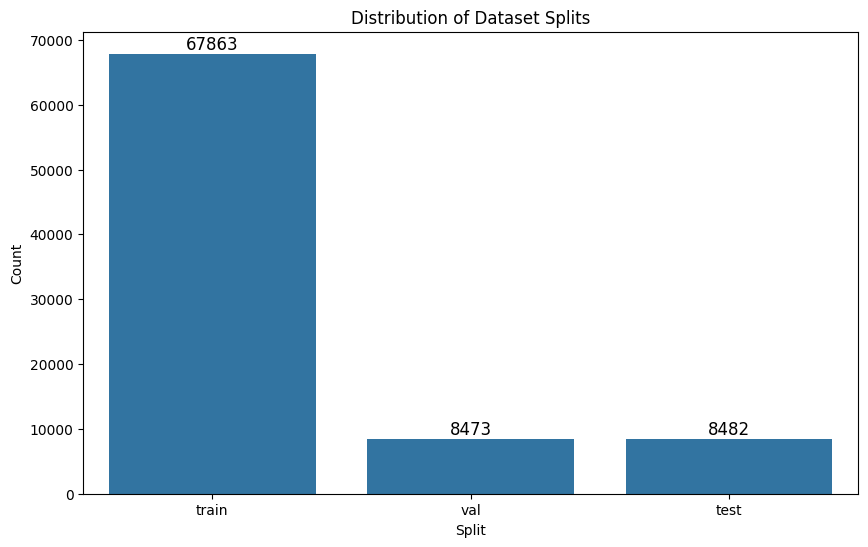

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of splits
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='split', data=df, order=['train', 'val', 'test'])
plt.title('Distribution of Dataset Splits')
plt.xlabel('Split')
plt.ylabel('Count')

# Add count labels clearly on top of bars
for container in ax.containers:
    ax.bar_label(container, fontsize=12)

plt.show()

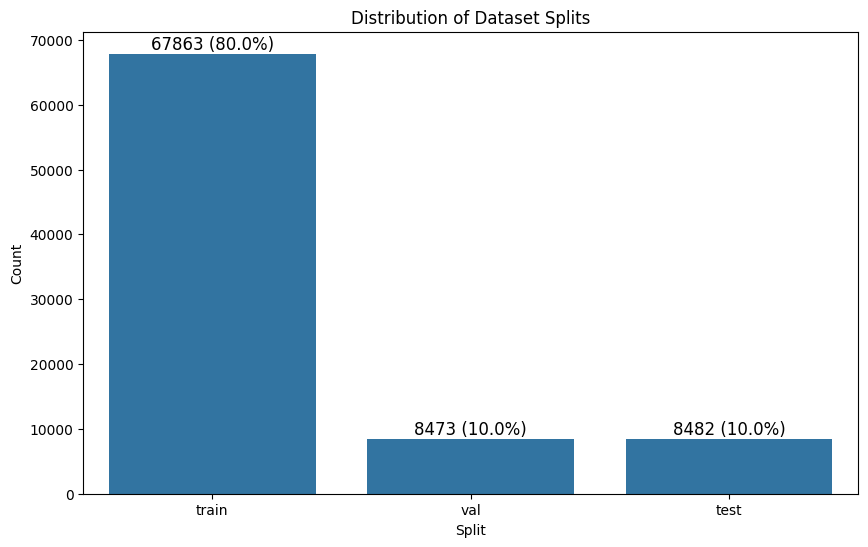

In [72]:
# Plot the distribution of splits with percentages
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='split', data=df, order=['train', 'val', 'test'])
plt.title('Distribution of Dataset Splits')
plt.xlabel('Split')
plt.ylabel('Count')

# Calculate total for percentages
total = len(df)

# Add count and percentage labels
for p in ax.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count} ({percentage})', (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

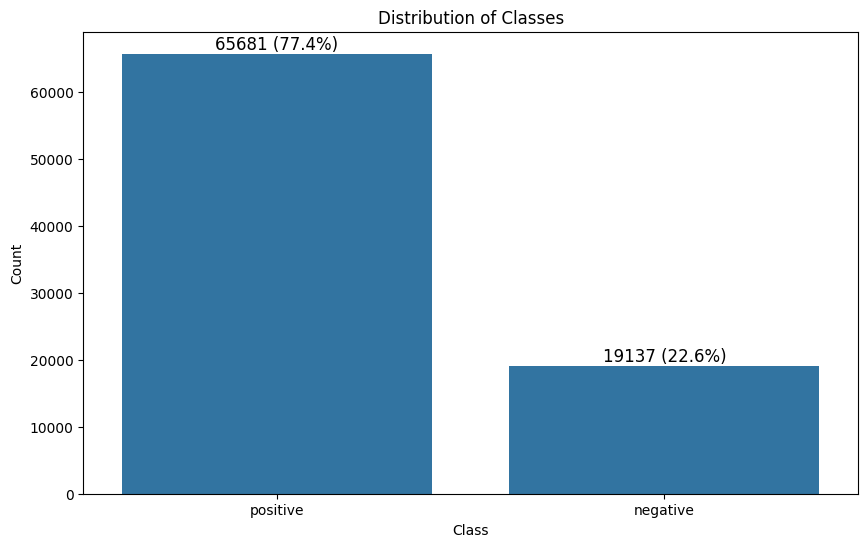

In [73]:
# Plot the distribution of classes with percentages
plt.figure(figsize=(10, 6))
class_counts = df['class'].value_counts()
ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')

# Calculate total for percentages
total = len(df)

# Add count and percentage labels
for p in ax.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count} ({percentage})', (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

In [74]:
# Extract projection (AP/PA) from filename
# Note: 'p' is not a valid hex character (0-9, a-f), so 'ap'/'pa' substrings are safe to search.

def extract_projection(filename):
    fname = str(filename).lower()
    if 'ap' in fname:
        return 'AP'
    elif 'pa' in fname:
        return 'PA'
    return 'Unknown'

df['projection'] = df['filename'].apply(extract_projection)

# Display counts
print("Projection counts:")
print(df['projection'].value_counts())

# Show sample of extracted views
print("\nSample with projection:")
print(df[df['projection'] != 'Unknown'][['filename', 'projection']].head())


Projection counts:
projection
AP         39951
PA         25069
Unknown    19798
Name: count, dtype: int64

Sample with projection:
                                filename projection
252      parapneumonic-effusion-1-PA.png         AP
253  right-upper-lobe-pneumonia-9-PA.jpg         PA
254           chlamydia-pneumonia-PA.png         PA
259   cavitating-pneumonia-4-day0-PA.jpg         PA
260  cavitating-pneumonia-4-day28-PA.png         PA


In [75]:
# Refine projection extraction using Regex to avoid false positives
import re

def extract_projection_refined(filename):
    fname = str(filename)
    # Look for AP or PA surrounded by delimiters (non-word context) or start/end of string.
    # (?:^|[\W_]) matches start or non-alphanumeric (including underscore)
    # (?i) makes it case-insensitive
    match = re.search(r'(?i)(?:^|[\W_])(AP|PA)(?:$|[\W_])', fname)
    if match:
        return match.group(1).upper()
    return 'Unknown'

df['projection'] = df['filename'].apply(extract_projection_refined)

# Display new counts
print("Refined Projection counts:")
print(df['projection'].value_counts())

# Verify specific false positive case if present
print("\nVerification (parapneumonic...):")
sample_fp = df[df['filename'].str.contains('parapneumonic', case=False, na=False)]
if not sample_fp.empty:
    print(sample_fp[['filename', 'projection']].head())


Refined Projection counts:
projection
AP         39915
PA         25093
Unknown    19810
Name: count, dtype: int64

Verification (parapneumonic...):
                            filename projection
252  parapneumonic-effusion-1-PA.png         PA


In [76]:
# Extract suffix after AP/PA label to identify subtypes (e.g., 'supine')

def extract_projection_suffix(filename):
    fname = str(filename)
    # 1. Find AP or PA (same logic as before: delimited)
    match = re.search(r'(?i)(?:^|[\W_])(AP|PA)([\W_].*)?$', fname)
    if match:
        # group 2 is the suffix (starting with delimiter)
        suffix = match.group(2)
        if suffix:
            # Clean up: remove leading delimiter and common extensions
            suffix = suffix.lstrip('-_ .')
            for ext in ['.png', '.jpg', '.jpeg']:
                if suffix.lower().endswith(ext):
                    suffix = suffix[:-len(ext)]
            return suffix if suffix else ''
        return ''
    return ''

df['projection_extra'] = df['filename'].apply(extract_projection_suffix)

# Display counts of non-empty suffixes
print("Projection Suffix counts (subtypes):")
print(df[df['projection_extra'] != '']['projection_extra'].value_counts())

# Show sample with suffixes
print("\nSample with extra info:")
print(df[df['projection_extra'] != ''][['filename', 'projection', 'projection_extra']].head(10))


Projection Suffix counts (subtypes):
projection_extra
dx-corrected                                  30524
cr-corrected                                  20830
png                                               9
jpg                                               6
jpeg                                              3
                                              ...  
AP_AND_LATERAL-76707-2.000000-PA-90987-1-1        1
VIEWONLY-47883-2.000000-AP-38851-1-1              1
VIEWONLY-47883-1.000000-AP-34180-1-1              1
VIEWONLY-45691-1.000000-AP-20543-1-1              1
VIEWONLY-45691-2.000000-AP-55884-1-1              1
Name: count, Length: 13641, dtype: int64

Sample with extra info:
                                              filename projection  \
252                    parapneumonic-effusion-1-PA.png         PA   
253                right-upper-lobe-pneumonia-9-PA.jpg         PA   
254                         chlamydia-pneumonia-PA.png         PA   
259                 cavitating-p

In [77]:
# Fix suffix extraction (remove extensions correctly) and Group Projections

def extract_suffix_fixed(filename):
    fname = str(filename)
    # Find AP or PA followed by suffix
    match = re.search(r'(?i)(?:^|[\W_])(AP|PA)([\W_].*)?$', fname)
    if match:
        suffix = match.group(2)
        if suffix:
            # Remove extension BEFORE stripping delimiters to handle cases like '-PA.png'
            lower_suffix = suffix.lower()
            for ext in ['.png', '.jpg', '.jpeg']:
                if lower_suffix.endswith(ext):
                    suffix = suffix[:-len(ext)]
                    lower_suffix = lower_suffix[:-len(ext)]
                    break
            
            # Now strip leading/trailing delimiters (e.g. - . _)
            suffix = suffix.strip('-_ .')
            return suffix
    return ''

# 1. Update projection_extra with fixed logic
df['projection_extra'] = df['filename'].apply(extract_suffix_fixed)

# 2. Create Grouping Column
def categorize_projection(row):
    proj = row['projection']
    extra = row['projection_extra']
    if proj == 'Unknown':
        return 'Unknown'
    if extra == '':
        return proj  # Pure AP or PA
    else:
        return f"{proj} with text"

df['projection_group'] = df.apply(categorize_projection, axis=1)

# 3. Display Counts
print("Projection Group Counts:")
print(df['projection_group'].value_counts())

# 4. Show examples of 'With Text'
print("\nExamples of AP/PA with text:")
print(df[df['projection_group'].str.contains('with text')][['filename', 'projection_group', 'projection_extra']].head())


Projection Group Counts:
projection_group
AP with text    39915
PA with text    25075
Unknown         19810
PA                 18
Name: count, dtype: int64

Examples of AP/PA with text:
                                                filename projection_group  \
11826  A373370-01-20-1901-NA-CHEST_AP_PORT-77753-2.00...     AP with text   
11827  A373370-01-20-1901-NA-CHEST_AP_PORT-36796-1.00...     AP with text   
11828  A373370-01-20-1901-NA-CHEST_AP_PORT-36796-2.00...     AP with text   
11829  A373370-01-17-1901-NA-CHEST_AP_PORT_CENTRAL_LI...     AP with text   
11830  A373370-01-17-1901-NA-CHEST_AP_PORT_CENTRAL_LI...     AP with text   

                                       projection_extra  
11826                  PORT-77753-2.000000-AP-91595-1-1  
11827                  PORT-36796-1.000000-AP-04209-1-1  
11828                  PORT-36796-2.000000-AP-61514-1-1  
11829  PORT_CENTRAL_LINE_PL-40193-2.000000-AP-11790-1-1  
11830  PORT_CENTRAL_LINE_PL-40193-1.000000-AP-66565-1-1  


In [78]:
df.to_csv('covidx_merged.csv', index=False)